<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/dev/notebooks/chagas_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Chagas Disease from the ECG

Questo progetto è ispirato dalla [George B. Moody PhysioNet Challenge 2025](https://moody-challenge.physionet.org/2025/).

La **malattia di Chagas** è una patologia parassitaria diffusa in America Centrale e Meridionale, che può causare gravi danni al sistema cardiovascolare. La diagnosi è spesso tardiva a causa di un lungo periodo asintomatico. I test sierologici, pur essendo specifici, sono costosi e disponibili in quantità limitate, il che ne impedisce l’uso come strumento di screening di massa. Tuttavia, i trattamenti farmacologici esistenti risultano tanto più efficaci quanto prima vengono somministrati, rendendo cruciale l’identificazione precoce dei soggetti a rischio.

L'obiettivo del progetto è sviluppare una rete neurale in grado di analizzare **elettrocardiogrammi** (ECG) - un esame non invasivo, economico e ampiamente diffuso - per effettuare una pre-selezione dei pazienti da sottoporre al test sierologico, ottimizzando così l’impiego delle risorse disponibili.

Il modello potrà inoltre fornire un supporto clinico segnalando precocemente l’insorgenza di eventuali complicanze, consentendo un intervento tempestivo nei casi in cui la terapia risulta più efficace.

L'esperimento è reperibile su [GitHub](https://github.com/dokunoale/chagas.git).



## Introduzione

L’obiettivo del nostro progetto è sviluppare un modello di classificazione binaria che, a partire dai dati ECG, sia in grado di predire la presenza della malattia di Chagas. Il modello dovrà fornire sia un'**etichetta binaria** (positivo/negativo) sia la **probabilità** associata alla presenza della malattia.

Ciascun campione è costituito da una sequenza ECG di 7 secondi, registrata a 400 Hz su 12 derivazioni, per una dimensione complessiva di (2800, 12). Il progetto prevede la sperimentazione di diversi modelli di deep learning specificamente progettati per l’analisi di segnali ECG, al fine di individuare l’architettura più adatta al nostro contesto applicativo.

In [1]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -q -r chagas/requirements.txt

import sys
sys.path.append("/content/chagas/src")

Cloning into 'chagas'...
remote: Enumerating objects: 732, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 732 (delta 89), reused 62 (delta 53), pack-reused 565 (from 2)
Receiving objects: 100% (732/732), 12.36 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (363/363), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 21.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

## Dataset

I dati includono una parte del dataset [CODE-15%](https://zenodo.org/records/4916206) e il dataset [SaMi-Trop](https://zenodo.org/records/4905618), le etichette sulla malattia di Chagas sono fornite dalla piattaforma PhisioNet. Il dataset è bilanciato, con 5611 casi positivi e 5611 casi negativi.

- **CODE-15%** contiene oltre 300mila record di ECG raccolti in Brasile tra il 2010 e il 2016. Le etichette binarie di Chagas sono auto-riportate e pertanto potrebbero essere state validate o meno. Da questo dataset abbiamo estratto 3.980 campioni positivi e 5611 negativi.

- **Sami-Trop** contiene 1.631 registrazioni ECG a 12 derivazioni raccolte da pazienti affetti da malattia di Chagas in Brasile tra il 2011 e il 2012. e etichette di Chagas sono convalidate da test sierologici e sono tutte positive.



### Formato dei dati

I dati sono archiviati in file nel formato **WFDB**, composto da:

- un file di segnale in formato binario `.dat` che contiene i dati grezzi del segnale ECG
- un file d'intestazione `.hea`, che specifica informazioni quali la frequenza di campionamento, la durata del segnale, la risoluzione e i nomi dei canali ECG, nonché i valori iniziali e i checksum per ciascun canale. Include dati demografici e le etichette di Chagas, sotto forma di commento.

Ad esempio il seguente file, chiamato `14.hea`, associato al file `14.dat`, rappresenta un campione a 12 derivazioni, campionato a 400$Hz$ e composto da 4096 rilevazioni. Il paziente è una donna di 74 anni, presumibilmente negativa alla malattia di Chagas.
```text
14 12 400 4096
14.dat 16 1000(0)/mV 16 0 107 8680 0 I
14.dat 16 1000(0)/mV 16 0 1227 -1353 0 II
14.dat 16 1000(0)/mV 16 0 1120 -10000 0 III
14.dat 16 1000(0)/mV 16 0 -671 21850 0 AVR
14.dat 16 1000(0)/mV 16 0 -511 -31211 0 AVL
14.dat 16 1000(0)/mV 16 0 1174 -13411 0 AVF
14.dat 16 1000(0)/mV 16 0 -457 14574 0 V1
14.dat 16 1000(0)/mV 16 0 -1204 26357 0 V2
14.dat 16 1000(0)/mV 16 0 846 5156 0 V3
14.dat 16 1000(0)/mV 16 0 -389 28928 0 V4
14.dat 16 1000(0)/mV 16 0 389 -18825 0 V5
14.dat 16 1000(0)/mV 16 0 -1623 4933 0 V6
# Age: 74
# Sex: Female
# Chagas label: False
# Source: CODE-15%
```

### *Split* e caricamento del dataset

I dati sono stati suddivisi staticamente nei set di **addestramento**, **validazione** e **test**, preservando in ciascuno la distribuzione originale dei dati provenienti dai dataset CODE-15% e SaMi-Trop.

Il dataset è diviso come segue

- training set (70%): 3935 positivi, 3920 negativi

- validation set (10%): 557 positivi, 565 negativi

- test set (20%): 1119 positivi, 1126 negativi

In [ ]:
# Download the dataset
import gdown
url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=87d97e6a-402f-4803-9ce6-6ffe793751e0
To: /content/dataset.zip
100%|██████████| 623M/623M [00:06<00:00, 103MB/s]


Una classe custom `WfdbLoader` permette la conversione dei dati in formato WFDB in **numpy** array leggibili da **TensorFlow**. Contestualmente al caricamento dei dati, applica una prima normalizzazione, per avere tutti i dati all'interno dello stesso intervallo.

In [ ]:
from preprocessing.tf_dataset_loader import WfdbLoader
data_path = "/content/chagas/data/big_splitted_dataset/"

# training set loading
train = WfdbLoader(label = 'Chagas label')
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading
validation = WfdbLoader(label = 'Chagas label')
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading
test = WfdbLoader(label = 'Chagas label')
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()


Loading records: 100%|██████████| 557/557 [00:03<00:00, 161.18record/s]


(557, 2800, 12) (557,)


## Preprocessing

In questo paragrafo esploreremo i segnali presenti nel dataset utilizzando un campione ridotto e un modello semplificato, con l’obiettivo di individuare eventuali criticità nei dati. Il layer dedicato alla generazione dello spettrogramma verrà descritto in dettaglio nel paragrafo successivo, dedicato all’architettura dei modelli.


In [ ]:
from preprocessing.filters import FiltfiltNoiseReducer
from preprocessing.tf_dataset_loader import WfdbLoader
from models.layers import LightLogSpectrogram
from models.utils import show_spectrogram_from_sample, show_raw_ecg_from_sample

def naive_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = LightLogSpectrogram()(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.models.Model(inputs, outputs)


data_path = "/content/chagas/data/big_splitted_dataset/"
examples, _ = WfdbLoader(label = 'Chagas label').add_dataset(data_path + "train/positives").load(verbose=True, limit=10)
raw_sample = examples[3]

Loading records: 100%|██████████| 100/100 [00:00<00:00, 238.32record/s]


Questi dati, rappresentando esempi realistici di segnali ECG del mondo reale, possono contenere artefatti sia visibili che difficilmente percettibili a occhio nudo.
Dall'analisi dei grafici emerge chiaramente la presenza significativa di rumore di fondo. Si osserva inoltre una marcata eterogeneità nella qualità del segnale, con alcuni lead che mostrano forme d'onda più nitide e regolari, mentre altri presentano tracciati più disturbati e irregolari. Questa variabilità è tipica delle registrazioni ECG cliniche reali, dove fattori come il posizionamento degli elettrodi, i movimenti del paziente e le interferenze ambientali possono influenzare significativamente la qualità della registrazione.

L'analisi dello **spettrogramma** rivela chiaramente la correlazione tra le caratteristiche del segnale grezzo e la loro rappresentazione nel dominio tempo-frequenza: gli ampi movimenti e le vibrazioni di bassa frequenza (artefatti da movimento del paziente, deriva della linea di base, interferenze respiratorie) si manifestano come bande ad alta intensità nella parte inferiore dello spettrogramma, mentre i disturbi ad alta frequenza - principalmente interferenze elettriche della rete di alimentazione, problemi di messa a terra e rumore elettronico - appaiono come linee orizzontali marcate nella parte superiore, risultando chiaramente identificabili nonostante la loro ampiezza relativamente piccola nel segnale temporale grazie alla loro natura quasi-stazionaria e frequenza caratteristica.

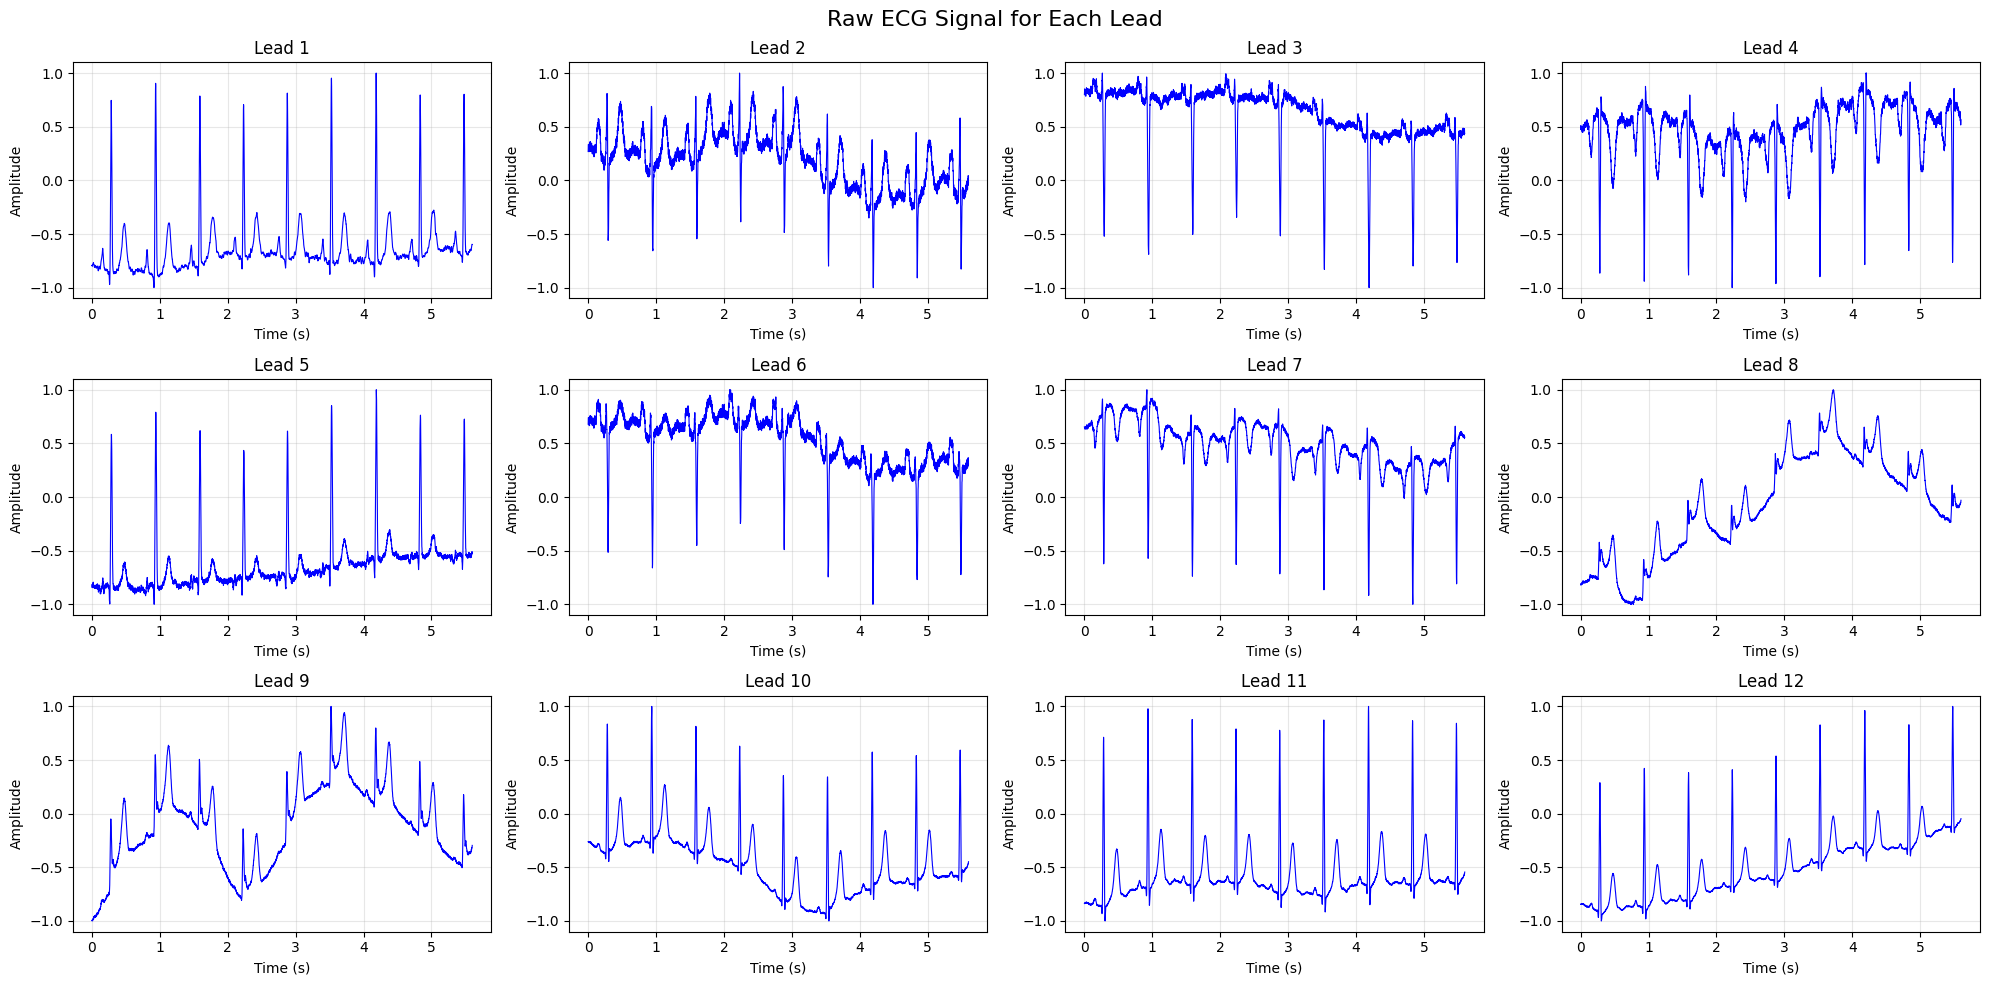

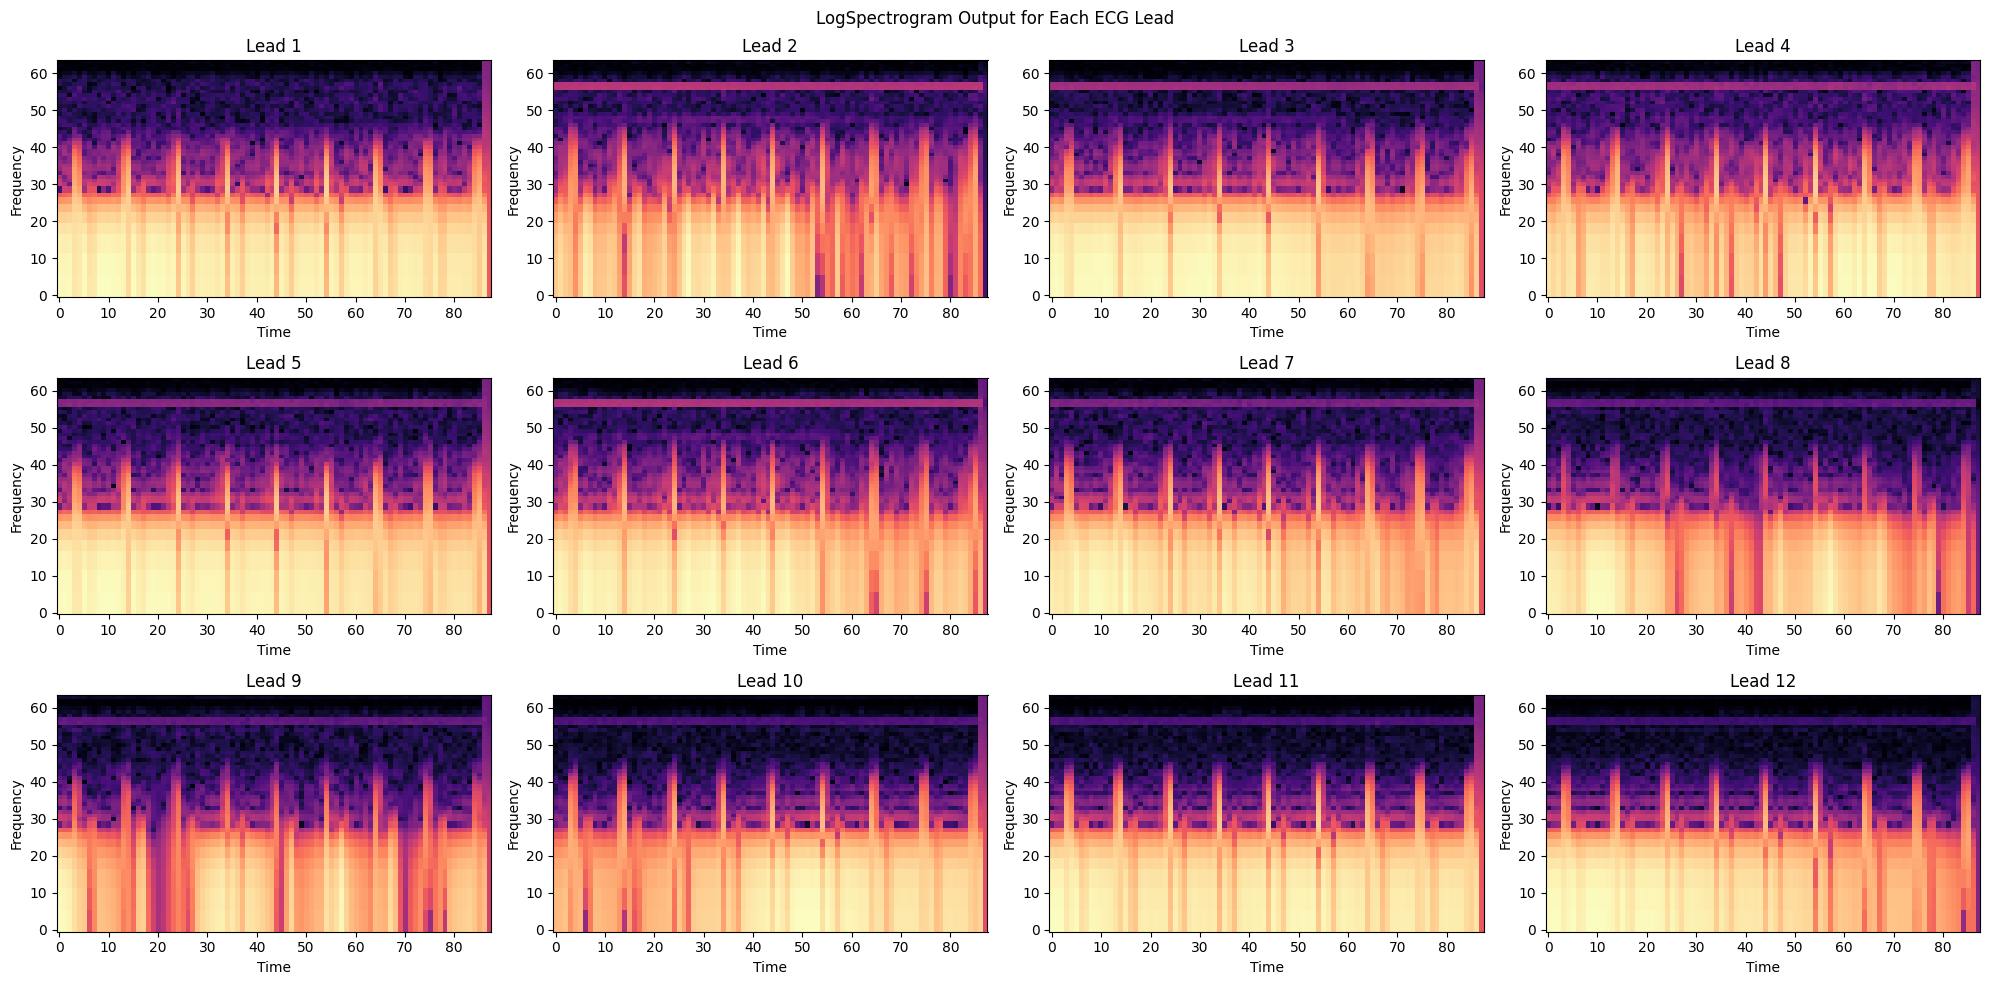

In [ ]:
show_raw_ecg_from_sample(raw_sample)
show_spectrogram_from_sample(naive_model((2800, 12)), raw_sample)

Risulta chiara la necessita di ripulire il segnale da queste interferenze. Il **denoiser** utilizzato è ispirato alla fase di preprocessing descritta nello studio [ECG biometric recognition: Permanence analysis of QRS signals for 24 hours continuous authentication](https://ieeexplore.ieee.org/abstract/document/6707790/authors#authors).

Abbiamo ricostruito l'architettura descritta nel paper nella classe custom `FiltfiltNoiseReducer`.

- **Filtro Notch** (IIR): Il filtro notch (di default a 60 Hz, frequenza della rete elettrica brasiliana) elimina le linee orizzontali marcate visibili nella parte superiore dello spettrogramma, corrispondenti alle interferenze elettriche della rete di alimentazione e ai disturbi di messa a terra.

- **Filtro High-pass Butterworth**: Il filtro high-pass rimuove le bande ad alta intensità nella parte inferiore dello spettrogramma, eliminando le componenti a bassa frequenza generate dai movimenti del paziente, dalla deriva della linea di base e dalle variazioni di contatto degli elettrodi che causano l'instabilità visibile nei segnali grezzi.

- **Filtro Low-pass** (opzionale): Il filtro low-pass (default 60 Hz) attenua le componenti ad alta frequenza residue come il rumore muscolare e le interferenze elettromagnetiche, che contribuiscono al rumore generale dei tracciati senza fornire informazioni clinicamente rilevanti per l'analisi ECG.

`FiltfiltNoiseReducer` applica i filtri attraverso la funzione `filtfilt` che implementa un **filtraggio a fase zero**, garantendo l'assenza di sfasamenti nel segnale filtrato e preservando la morfologia dei tracciati ECG con l'allineamento temporale preciso dei complessi QRS. La funzione filtra il segnale prima in avanti e poi all'indietro: questo doppio passaggio cancella le distorsioni di fase introdotte dal filtro, eliminando ritardi temporali che potrebbero compromettere l'analisi clinica e mantenendo il segnale temporalmente fedele all'originale.

Filtering records - filtfilt: 100%|██████████| 1/1 [00:00<00:00, 146.94record/s]


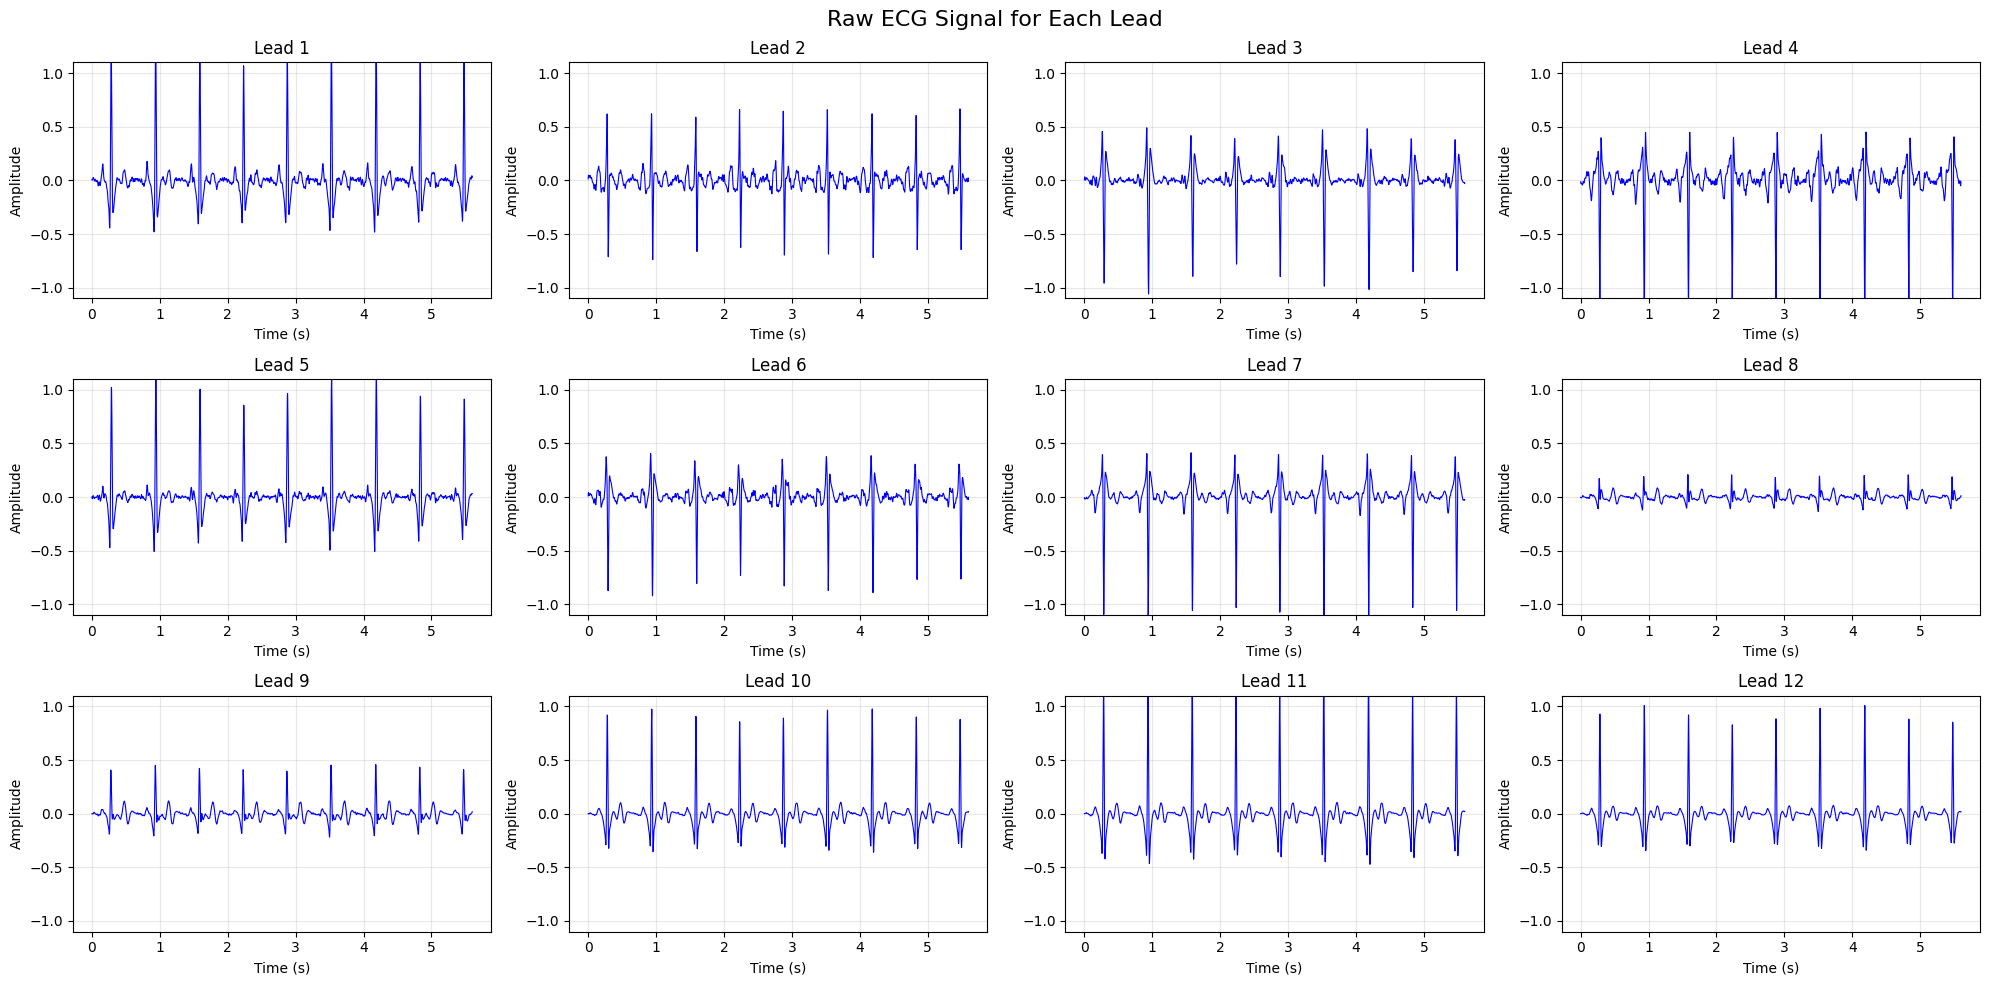

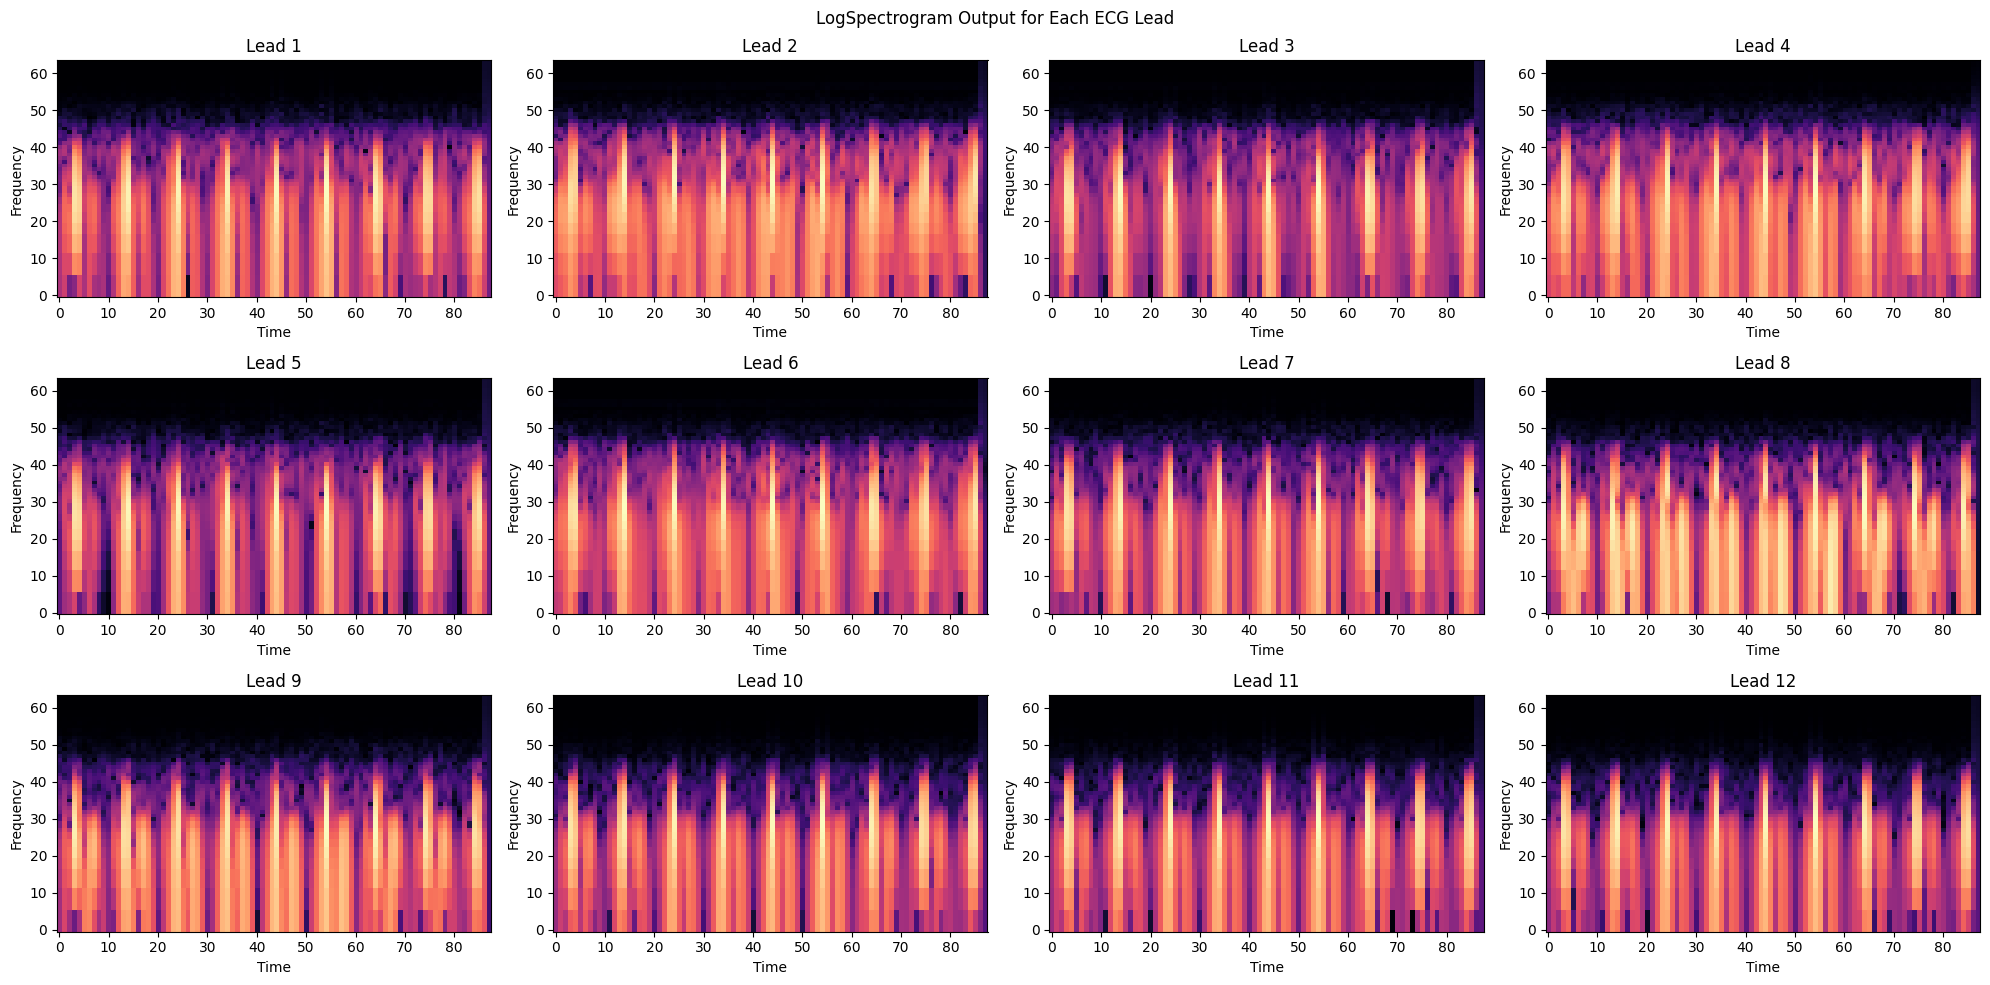

In [ ]:
preprocessed_example = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)([raw_sample])[0]

show_raw_ecg_from_sample(preprocessed_example)
show_spectrogram_from_sample(naive_model((2800, 12)), preprocessed_example)


## Modelli

Nel nostro percorso sperimentale abbiamo preso in esame alcune delle principali architetture impiegate nella classificazione di sequenze temporali, adattandole al contesto specifico dei segnali ECG, che si distinguono per la presenza di pattern geometrici ricorrenti. L’obiettivo era valutare come questi modelli si comportano di fronte a dati brevi, grezzi e multicanale, tipici della pratica clinica.

Per confrontare le diverse soluzioni, abbiamo scelto di monitorare due metriche chiave: l’accuratezza, che fornisce una misura diretta delle previsioni corrette, e l’AUC (Area Under the Curve), particolarmente rilevante in ambito clinico per la sua capacità di misurare la discriminazione tra classi.
Le reti sono state addestrate con l’ottimizzatore Adam, mentre la funzione di perdita adottata è la Binary Cross Entropy, standard per i problemi di classificazione binaria.

### GRU e LSTM

In una prima fase abbiamo testato due modelli essenziali, ciascuno composto esclusivamente da due layer ricorrenti bidirezionali: uno basato su LSTM, l’altro su GRU, entrambi seguiti da una semplice testa di classificazione.

- Il modello **LSTM** risulta incapace di trovare pattern per la classificazione in questo set di dati, mantenendo una *accuracy* di $0.50$, ovvero producendo output casuali.

- Il modello **GRU** si dimostra più stabile, raggiungendo valori in *accuracy* di $0.70$ e in *AUC* di $0.75$ sul set di validazione.


### Estensione con layer convolutivi

Per migliorare la capacità dei modelli ricorrenti di apprendere dai segnali ECG grezzi, abbiamo introdotto una fase preliminare di elaborazione mediante due blocchi di convoluzione 1D. Questa componente convolutiva consente al modello di estrarre automaticamente pattern locali ricorrenti — come picchi, onde e variazioni improvvise — che rappresentano elementi fondamentali per la diagnosi cardiaca, ma che spesso sfuggono a una semplice elaborazione ricorrente.

- **Conv1D + LSTM**: la combinazione ha permesso di ottenere risultati solidi, con un'accuracy intorno a $0.70$ e un’AUC che ha raggiunto $0.78$, segnalando una maggiore capacità discriminativa rispetto alla versione senza convoluzioni.

- **Conv1D + GRU**: in questo caso l’accuracy si è mantenuta stabile attorno a $0.71$, ma si è osservato un ulteriore incremento dell’AUC fino a $0.79$, indicando una migliore sensibilità del modello nel distinguere tra classi positive e negative.


### Spettrogramma e Conv2D

Il lavoro [*Convolutional Recurrent Neural Networks for Electrocardiogram Classification*](https://ieeexplore.ieee.org/document/8331491) mostra come l’integrazione tra rappresentazioni spettrali e modelli ibridi basati su convoluzioni e reti ricorrenti possa migliorare sensibilmente la classificazione dei segnali ECG. Gli autori osservano, in particolare, che *i primi esperimenti hanno mostrato come la trasformazione logaritmica migliori in modo significativo l'accuratezza della classificazione*, evidenziando il valore di questa operazione nel pre-processing del segnale.

Seguendo questa indicazione, abbiamo implementato un layer personalizzato che trasforma le sequenze ECG in spettrogrammi logaritmici, focalizzandosi sulle bande di frequenza più rilevanti per questo tipo di segnali.

`LightLogSpectrogram` trasforma segnali ECG grezzi in una rappresentazione spettrale più compatta e informativa. Per ciascun canale (lead), il layer applica una Trasformata di Fourier a breve termine (STFT) su finestre temporali sovrapposte, restituendo un tensore complesso che rappresenta l’energia del segnale nelle varie frequenze nel tempo.

Successivamente, viene applicata una compressione dinamica tramite la funzione `log1p`, combinata con uno scaling costante (`scale=128.0`), per attenuare l’effetto dei picchi più intensi e migliorare la leggibilità dei pattern frequenziali. Per ridurre ulteriormente la dimensionalità e concentrarsi sulle frequenze clinicamente rilevanti, le componenti spettrali vengono poi raggruppate in modo non lineare su scala logaritmica, selezionando `num_log_bins` (ad esempio 64) bande di frequenza.

Questa trasformazione non solo migliora l’efficienza computazionale del modello, ma permette anche di evidenziare le strutture ritmiche più significative, facilitando l’apprendimento da parte dei modelli convolutivi.

Il codice seguente mostra un esempio di utilizzo del layer `LightLogSpectrogram` all'interno di un modello basato unicamente su convoluzioni. L'integrazione di questa rappresentazione spettrale ha portato a un incremento significativo delle performance, migliorando l’accuracy del modello anche senza l’impiego di componenti ricorrenti.


```python
def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="small_cnn")
```

![image](https://github.com/dokunoale/chagas/blob/dev/notebooks/assets/simple_models_comparison.png?raw=1)


### Recurrent CNN con GRU

In questo modello vengono integrati concetti già esplorati in esperimenti precedenti, tra cui semplici CNN, GRU e la loro combinazione con convoluzioni 1D. La componente convolutiva ha il ruolo di estrarre caratteristiche spaziali dallo spettro dei segnali ECG, mentre il blocco GRU ha il compito di trovare pattern nella sequenza temporale.

Per mantenere la coerenza temporale tra la parte convolutiva e quella ricorrente, è stato introdotto un layer di pooling temporale custom. Questo passaggio garantisce che le informazioni spaziali estratte conservino la loro struttura sequenziale, ottimizzando il passaggio alla modellazione ricorrente e preservando l’informazione dinamica fondamentale per i segnali ECG.